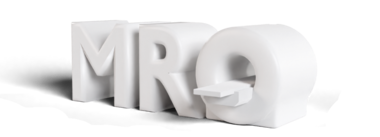

# **FID: free induction decay**
In this script a sequence and a phantom are set-up to simulate the measurement of the free induction decay signal.

References:
1.   https://mriquestions.com/free-induction-decay.html, last access: 16-05-2024



## 1. Library installation and download of phantom

In [34]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

## 2. Library import and setup

In [35]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt
from google.colab import files

## 3. Acquisition configuration

In [36]:
# Phantom resolution
sz = [64, 64]

# Field of view, imaging volume and resolution
fov = 200e-3
Nread = 256
Nphase = 1
slice_thickness = 8e-3  # slice

# Sequence's name
experiment_id = 'FID'
save = True
download = True

# Scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)

## 4. Phantom loading and configuration

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


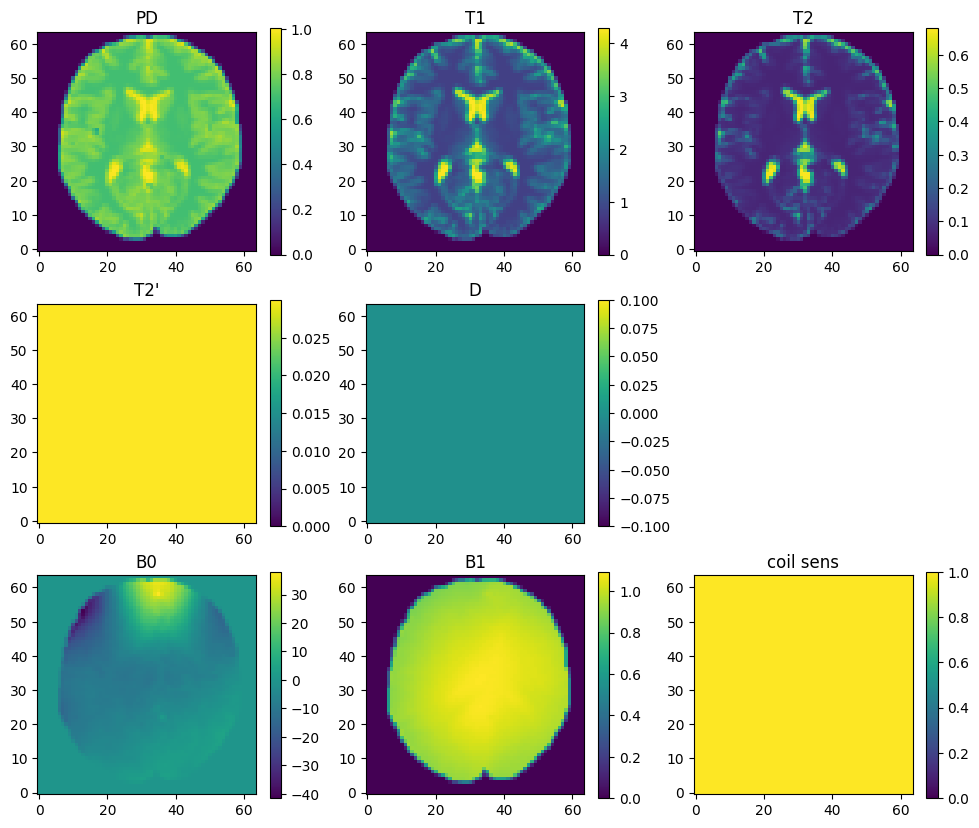

In [37]:
# Load phantom data
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
obj_p.D *= 0
obj_p.plot()


## 5. Sequence building

In [38]:
seq = pp.Sequence()

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    delay=0, system=system, return_gz=True
)

# Define other gradients and ADC events
adc = pp.make_adc(num_samples=Nread, duration=70e-3, phase_offset=0 * np.pi / 180, delay=0, system=system)

# Construct sequence
seq.add_block(rf1)
seq.add_block(adc)

# Bug: pypulseq 1.3.1post1 write() crashes when there is no gradient event
seq.add_block(pp.make_trapezoid('x', duration=5e-3, area=10))

# Verify sequence timing
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Write seq file
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'FID')
seq.write('FID.seq')

Timing check passed successfully


## 6. Simulation

### 6.1 Update phantom parameters for simulation

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


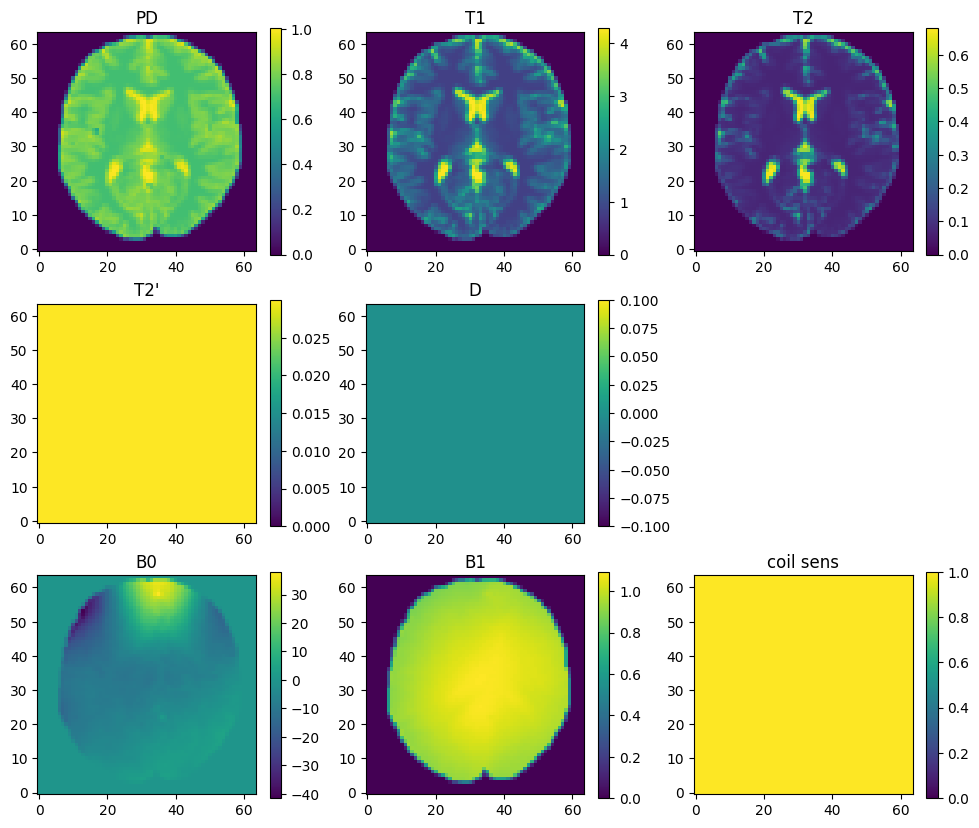

In [39]:
#@markdown  The B0 inhomogeneity brings you from the rotating frame FID at dB0=0, closer to the lab frame FID at dB0=B0.
#@markdown Try dB0=0 and dB0=500 for a test.
dB0 = 0 #@param {title:'dB0',type:"slider", min:0, max:500, step:10}

# Reload phantom
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
obj_p.D *= 0
obj_p.B0 += dB0
obj_p.plot()
# Convert phantom into simulation data
obj_p = obj_p.build()

### 6.2 Read seq file and simulate

In [ ]:
# Read in the sequence
seq0 = mr0.Sequence.import_file("FID.seq")

# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# Plot sequence with SIGNAL
sp_adc, t_adc = mr0.util.pulseq_plot(seq=seq,signal=signal.numpy())

## 7. Save results

In [ ]:
if save:
    dir = "./results/"
    np.savez_compressed(experiment_id + "_signal", signal)
    #np.savetxt(dir + experiment_id + "_signal.txt", signal)
    #plt.savefig(dir + experiment_id + "_signal.png")

    if download:
      files.download(experiment_id + "_signal.npz")

In [ ]:
print("End of notebook - saving numpy github")